In [1]:

from lsst.sims.maf.metrics.baseMetric import BaseMetric
import lsst.sims.maf.utils as mafUtils
import lsst.sims.utils as utils
from scipy import interpolate

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

import glob


In [2]:
# Copy and modify the ParallaxMetric

class BDParallaxMetric(BaseMetric):
    """Calculate the distance to which one could reach a parallax SNR for a given object

    Uses columns ra_pi_amp and dec_pi_amp, calculated by the ParallaxFactorStacker.

    Parameters
    ----------
    metricName : str, opt
        Default 'parallax'.
    m5Col : str, opt
        The default column name for m5 information in the input data. Default fiveSigmaDepth.
    filterCol : str, opt
        The column name for the filter information. Default filter.
    seeingCol : str, opt
        The column name for the seeing information. Since the astrometry errors are based on the physical
        size of the PSF, this should be the FWHM of the physical psf. Default seeingFwhmGeom.
    mags : dict
        The absolute magnitude of the obeject in question. Keys of filter name, values in mags.
    distances : np.array
        Distances to try putting the object at (pc).
    atm_err : float, opt
        The expected centroiding error due to the atmosphere, in arcseconds. Default 0.01.
    badval : float, opt
        The value to return when the metric value cannot be calculated. Default 0.
    """
    def __init__(self, metricName='bdParallax', m5Col='fiveSigmaDepth',
                 filterCol='filter', seeingCol='seeingFwhmGeom',
                 badval=0, mags={'z': 18.18, 'y': 17.13}, parallax_snr=10.,
                 distances=np.arange(10, 200, 20), 
                 atm_err=0.01, normalize=False, min_exp_time=15., 
                 exptimeCol='visitExposureTime', **kwargs):
        Cols = [m5Col, filterCol, seeingCol, exptimeCol, 'ra_pi_amp', 'dec_pi_amp']
        
        units = 'pc'
        super(BDParallaxMetric, self).__init__(Cols, metricName=metricName, units=units,
                                             badval=badval, **kwargs)
        # set return type
        self.m5Col = m5Col
        self.seeingCol = seeingCol
        self.filterCol = filterCol
        self.distances = distances
        self.exptimeCol = exptimeCol
        self.mags = {}
        distance_mod = 5.0*np.log10(distances)-5.0
        for key in mags:
            self.mags[key] = mags[key] + distance_mod
        self.parallax_snr_goal = parallax_snr
        self.atm_err = atm_err
        self.filters = list(self.mags.keys())
        self.parallaxes = 1000.0/distances  #mas
        self.min_exp_time = min_exp_time
        
    def _final_sigma(self, position_errors, ra_pi_amp, dec_pi_amp):
        """Assume parallax in RA and DEC are fit independently, then combined.
        All inputs assumed to be arcsec """
        sigma_A = position_errors/ra_pi_amp
        sigma_B = position_errors/dec_pi_amp
        sigma_ra = np.sqrt(1./np.sum(1./sigma_A**2, axis=1))
        sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2, axis=1))
        # Combine RA and Dec uncertainties, convert to mas
        sigma = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))*1e3
        return sigma

    def run(self, dataslice, slicePoint=None):
        snr = np.zeros((np.size(self.mags[self.filters[0]]), len(dataslice)), dtype='float')
        # compute SNR for all observations
        for filt in self.filters:
            if self.min_exp_time is not None:
                good = np.where((dataslice[self.filterCol] == filt) &
                                (dataslice[self.exptimeCol] >= self.min_exp_time))[0]
            else:
                good = np.where(dataslice[self.filterCol] == filt)[0]
            if np.size(good) > 0:
                snr[:, good] = mafUtils.m52snr(self.mags[str(filt)][:, np.newaxis],
                                               dataslice[self.m5Col][good])
                
        
        position_errors = np.sqrt(mafUtils.astrom_precision(dataslice[self.seeingCol],
                                                            snr)**2+self.atm_err**2)
        # uncertainty in the parallax in mas
        sigma = self._final_sigma(position_errors, dataslice['ra_pi_amp'], dataslice['dec_pi_amp'])
        fitted_parallax_snr = self.parallaxes/sigma
        result = self.badval
        # Let's interpolate to the distance where we would get our target SNR
        if np.max(fitted_parallax_snr) >= self.parallax_snr_goal:
            f = interpolate.interp1d(fitted_parallax_snr, self.distances, fill_value="extrapolate")
            result = f(self.parallax_snr_goal)
        return result

In [3]:
class VolumeSumMetric(BaseMetric):
    """Compute the total volume assuming a metric has values of distance
    """
    def __init__(self, col=None, metricName='VolumeSum', nside=None, **kwargs):
        super(VolumeSumMetric, self).__init__(col=col, metricName=metricName, **kwargs)
        self.pix_area = hp.nside2pixarea(nside)
        
    def run(self, dataSlice, slicePoint=None):
        # volume of sphere, times ratio of pixel area divided by area of sphere
        vols = 1./3. * dataSlice[self.colname]**3 * self.pix_area
        return np.sum(vols)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2235956 visits
Running:  ['_sims_maf_fbs_1_6_even_filters_even_filters_alt_g_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.9533  dipole: lon: 96.362, lat: -80.5208, amp: 17.9976
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2235070 visits
Running:  ['_sims_maf_fbs_1_6_even_filters_even_filters_altv1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.8915  dipole: lon: 99.7039, lat: -80.1913, amp: 18.0499
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2231516 visits
Running:  ['_sims_maf_fbs_1_6_even_filters_even_filters_g_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.9513  dipole: lon: 98.7256, lat: -80.0244, amp: 18.2596
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2230811 visits
Running:  ['_sims_maf_fbs_1_6_even_filters_even_filtersv1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 55.093  dipole: lon: 97.2624, lat: -80.2194, amp: 17.7649
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2142145 visits
Running:  ['_sims_maf_fbs_1_6_potential_schedulers_barebones_nexp2_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 201 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 63.6744  dipole: lon: 96.7924, lat: -67.7403, amp: 14.4227
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2232205 visits
Running:  ['_sims_maf_fbs_1_6_potential_schedulers_baseline_nexp1_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.8188  dipole: lon: 96.3024, lat: -80.5697, amp: 18.2797
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2064957 visits
Running:  ['_sims_maf_fbs_1_6_potential_schedulers_baseline_nexp2_scaleddown_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 51.2365  dipole: lon: 98.763, lat: -87.3828, amp: 22.21
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2064854 visits
Running:  ['_sims_maf_fbs_1_6_potential_schedulers_baseline_nexp2_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 53.5963  dipole: lon: 94.1168, lat: -82.0349, amp: 18.3792
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2069774 visits
Running:  ['_sims_maf_fbs_1_6_potential_schedulers_combo_dust_nexp2_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 49.4175  dipole: lon: 94.1663, lat: -83.5606, amp: 26.1631
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2237663 visits
Running:  ['_sims_maf_fbs_1_6_potential_schedulers_combo_dust_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 50.5191  dipole: lon: 93.733, lat: -82.5912, amp: 26.2947
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2066665 visits
Running:  ['_sims_maf_fbs_1_6_potential_schedulers_ddf_heavy_nexp2_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 51.9955  dipole: lon: 84.2371, lat: -83.7156, amp: 18.5657
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2232115 visits
Running:  ['_sims_maf_fbs_1_6_potential_schedulers_ddf_heavy_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 53.1719  dipole: lon: 92.4806, lat: -82.1938, amp: 18.6683
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2067057 visits
Running:  ['_sims_maf_fbs_1_6_potential_schedulers_dm_heavy_nexp2_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 53.0303  dipole: lon: 91.7934, lat: -81.7896, amp: 18.1604
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2234491 visits
Running:  ['_sims_maf_fbs_1_6_potential_schedulers_dm_heavy_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 53.9593  dipole: lon: 93.4671, lat: -81.0154, amp: 18.4507
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2065201 visits
Running:  ['_sims_maf_fbs_1_6_potential_schedulers_mw_heavy_nexp2_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 53.5887  dipole: lon: 89.7702, lat: -84.3763, amp: 19.0848
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2231775 visits
Running:  ['_sims_maf_fbs_1_6_potential_schedulers_mw_heavy_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.6427  dipole: lon: 98.0302, lat: -83.5258, amp: 19.0495
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2069994 visits
Running:  ['_sims_maf_fbs_1_6_potential_schedulers_rolling_exgal_mod2_dust_sdf_0_80_nexp2_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.1593  dipole: lon: 77.0427, lat: -83.9423, amp: 16.3819
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2237456 visits
Running:  ['_sims_maf_fbs_1_6_potential_schedulers_rolling_exgal_mod2_dust_sdf_0_80_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 55.4763  dipole: lon: 80.2298, lat: -83.0588, amp: 15.834
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2401217 visits
Running:  ['_sims_maf_fbs_1_6_potential_schedulers_ss_heavy_nexp2_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 53.5216  dipole: lon: 153.77, lat: -87.6484, amp: 18.3035
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2564237 visits
Running:  ['_sims_maf_fbs_1_6_potential_schedulers_ss_heavy_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.811  dipole: lon: 134.733, lat: -86.7745, amp: 18.3298
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2234674 visits
Running:  ['_sims_maf_fbs_1_6_rolling_fpo_rolling_fpo_2nslice0_8_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.9239  dipole: lon: 104.015, lat: -80.6555, amp: 18.0316
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2234785 visits
Running:  ['_sims_maf_fbs_1_6_rolling_fpo_rolling_fpo_2nslice0_9_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.9758  dipole: lon: 105.151, lat: -80.9333, amp: 17.9515
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2235333 visits
Running:  ['_sims_maf_fbs_1_6_rolling_fpo_rolling_fpo_2nslice1_0_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 55.0439  dipole: lon: 105.874, lat: -80.8864, amp: 17.675
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2233528 visits
Running:  ['_sims_maf_fbs_1_6_rolling_fpo_rolling_fpo_3nslice0_8_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 52.2316  dipole: lon: 105.853, lat: -86.7872, amp: 22.0709
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2233316 visits
Running:  ['_sims_maf_fbs_1_6_rolling_fpo_rolling_fpo_3nslice0_9_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 52.157  dipole: lon: 102.868, lat: -86.7934, amp: 22.2368
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2233796 visits
Running:  ['_sims_maf_fbs_1_6_rolling_fpo_rolling_fpo_3nslice1_0_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 51.9805  dipole: lon: 109.787, lat: -86.8629, amp: 22.5391
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2231920 visits
Running:  ['_sims_maf_fbs_1_6_rolling_fpo_rolling_fpo_6nslice0_8_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 52.3744  dipole: lon: 106.066, lat: -84.688, amp: 21.4724
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2232452 visits
Running:  ['_sims_maf_fbs_1_6_rolling_fpo_rolling_fpo_6nslice0_9_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 52.3908  dipole: lon: 107.068, lat: -84.6315, amp: 21.4305
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'visitExposureTime', 'seeingFwhmGeom', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter'].
Found 2232890 visits
Running:  ['_sims_maf_fbs_1_6_rolling_fpo_rolling_fpo_6nslice1_0_v1_6_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 52.5109  dipole: lon: 109.949, lat: -84.7104, amp: 21.2015
  mono, lon, lat, amp


Plotting complete.


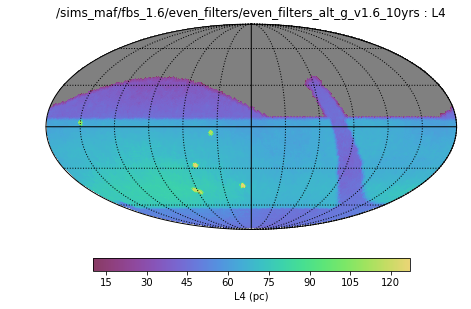

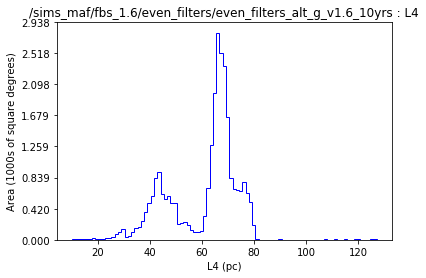

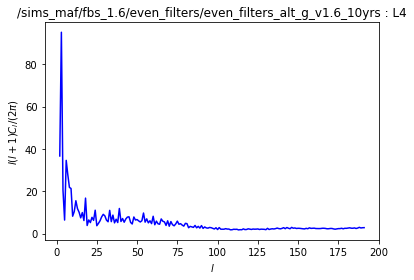

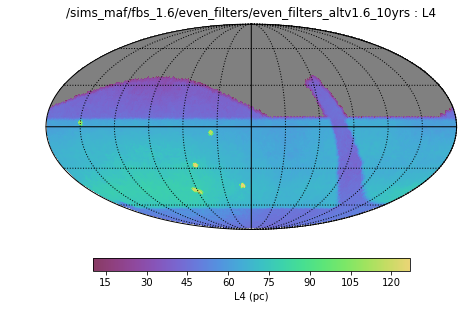

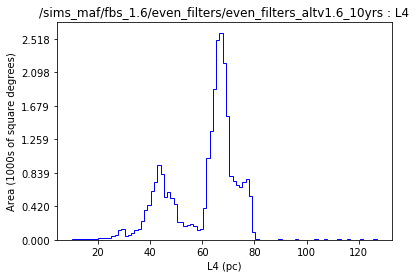

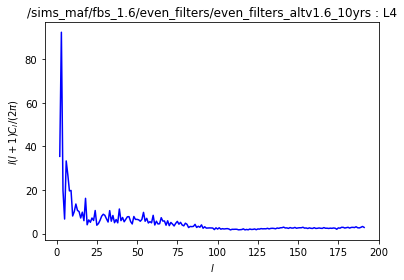

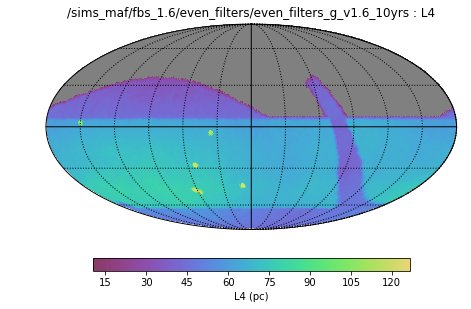

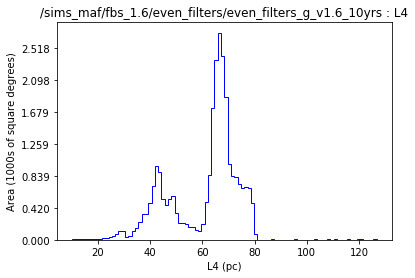

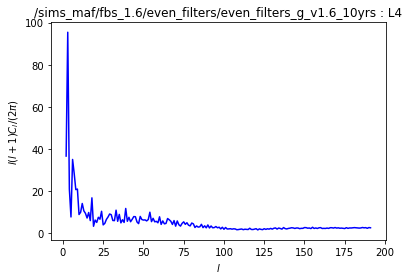

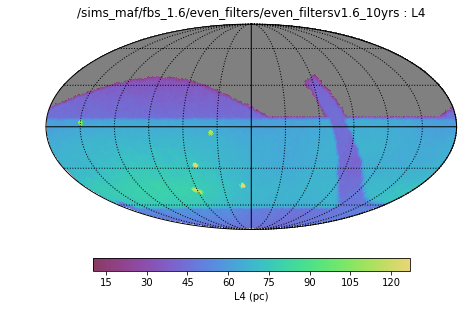

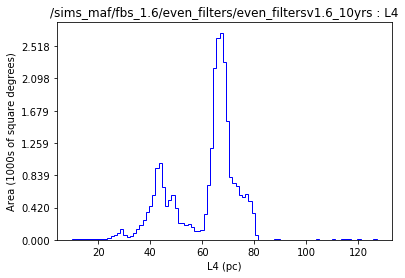

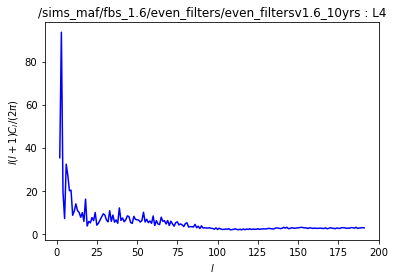

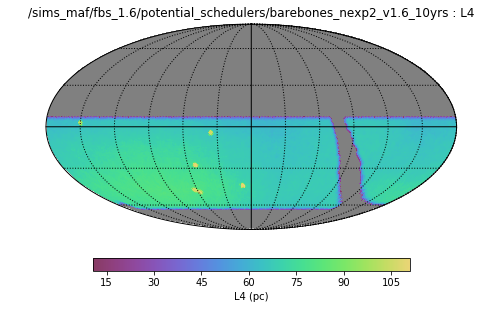

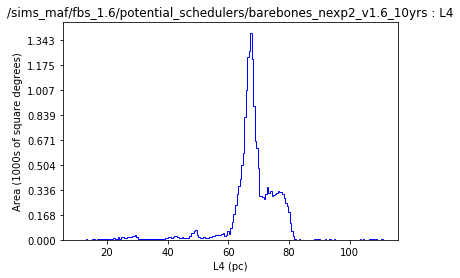

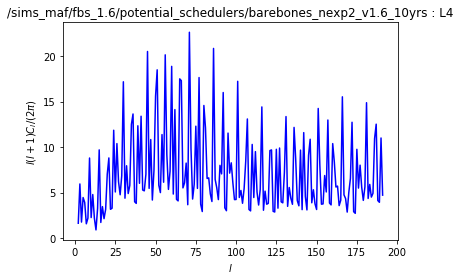

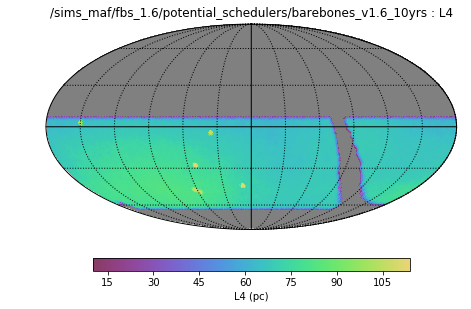

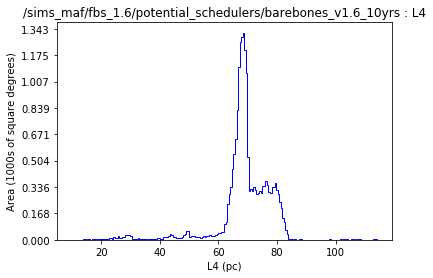

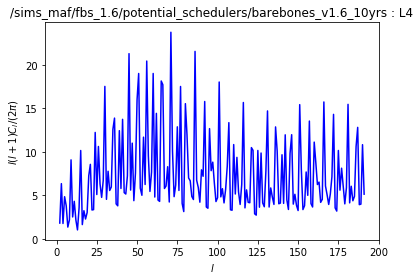

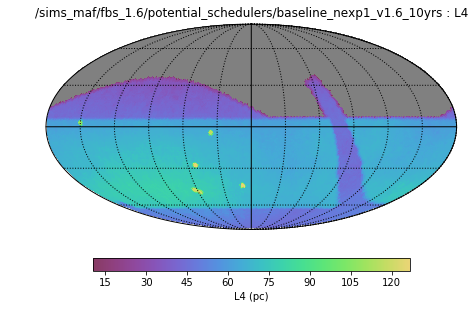

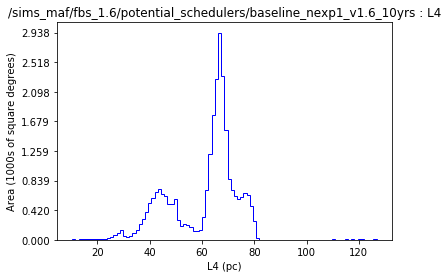

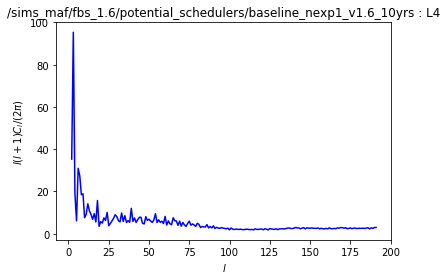

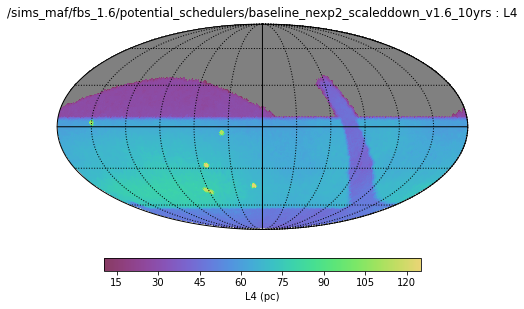

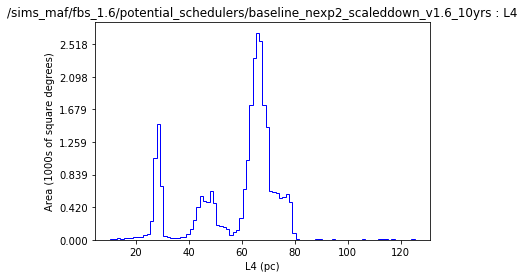

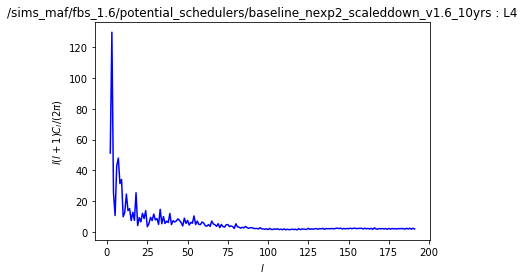

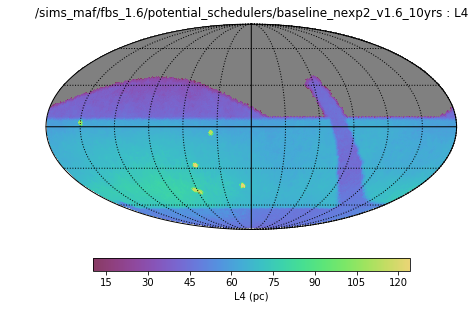

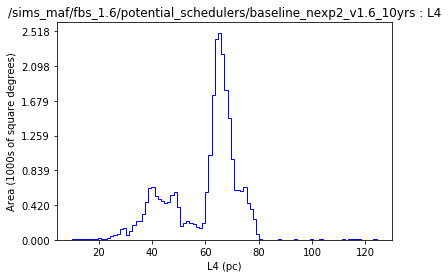

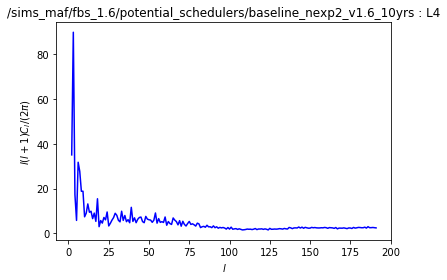

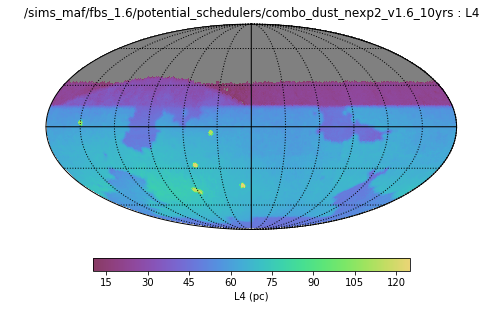

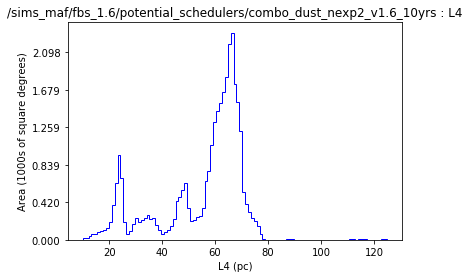

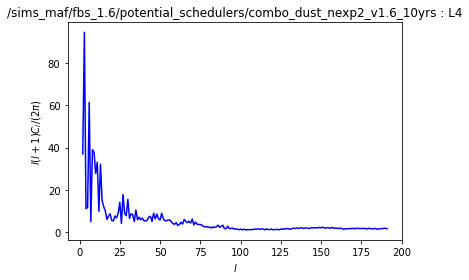

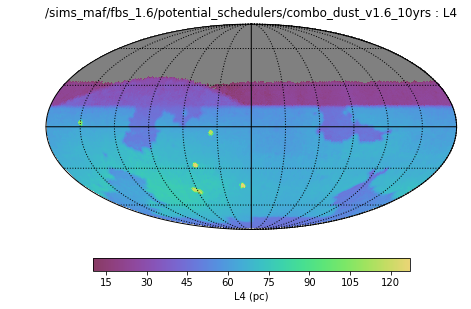

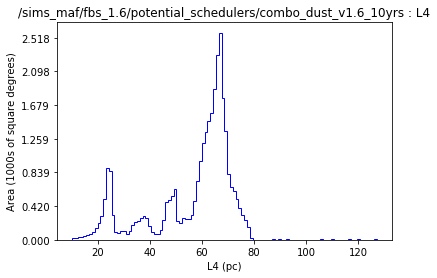

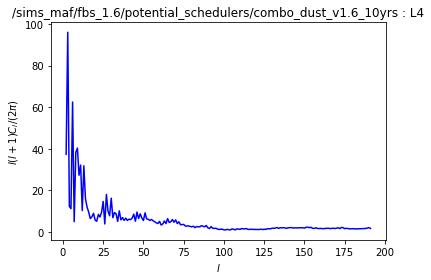

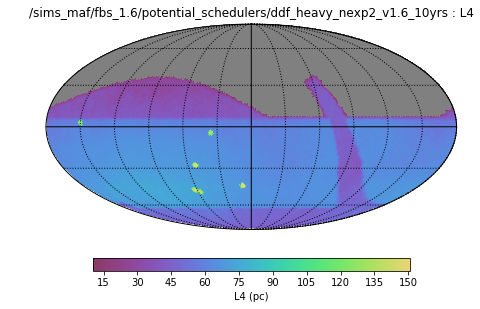

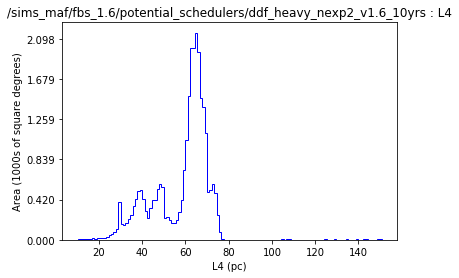

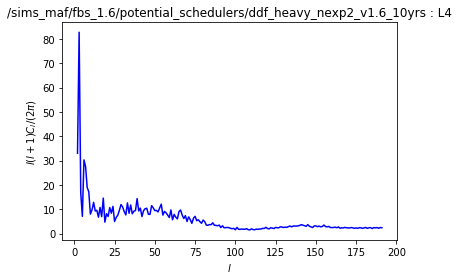

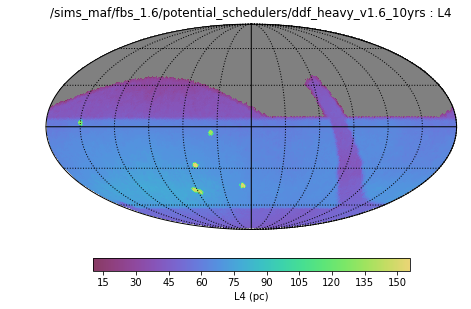

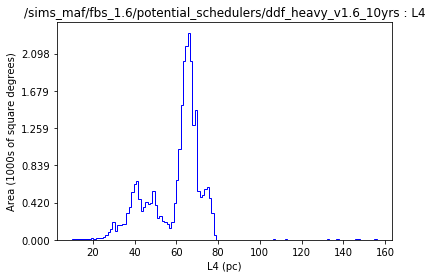

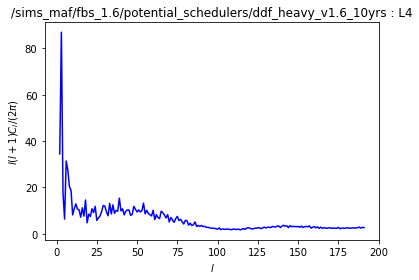

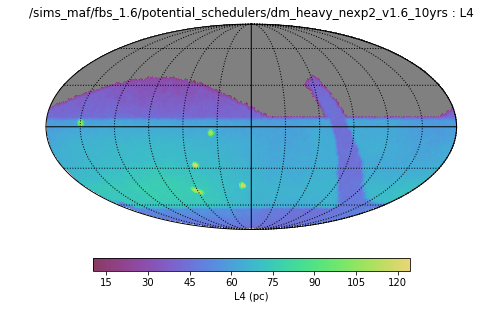

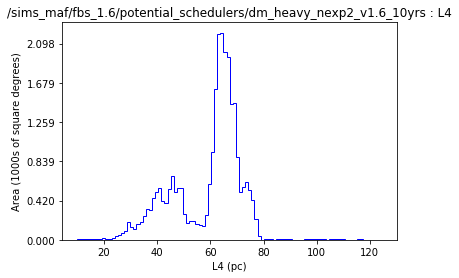

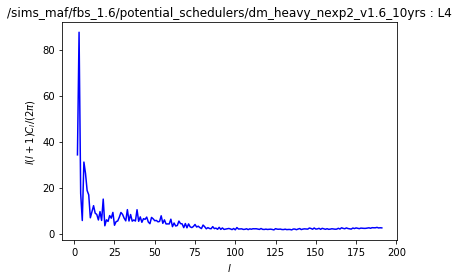

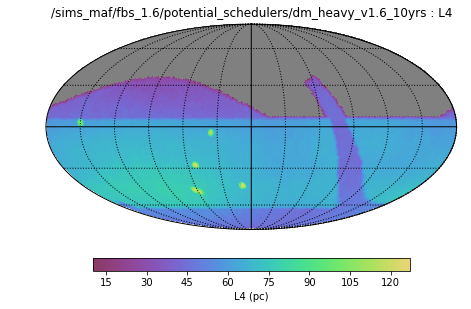

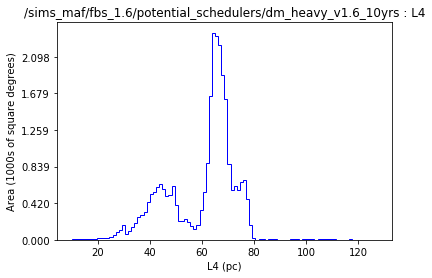

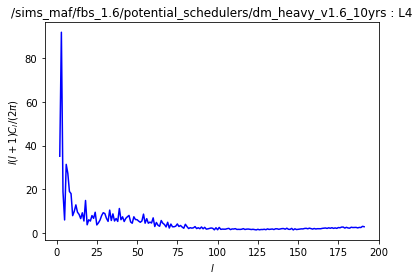

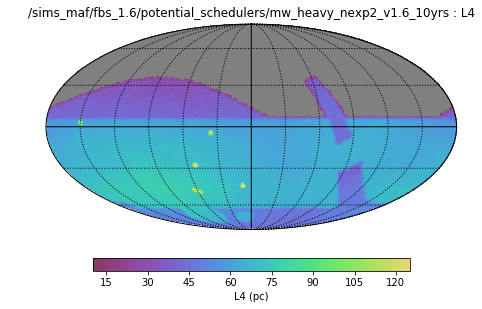

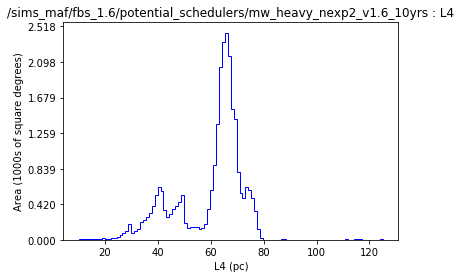

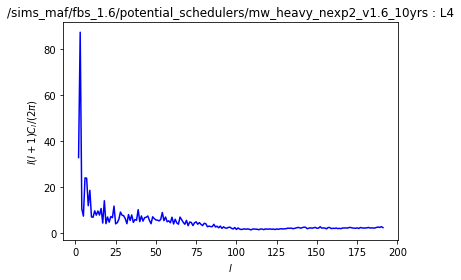

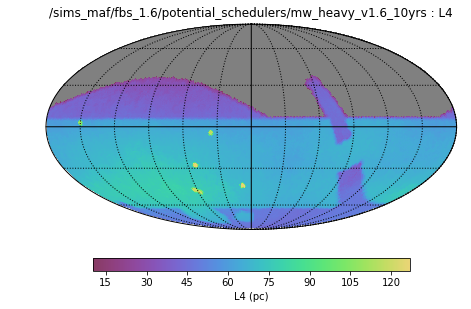

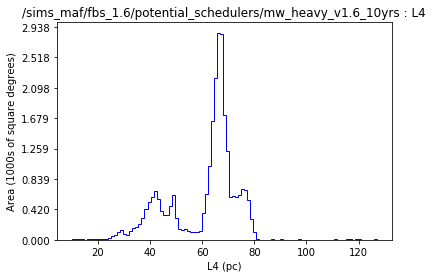

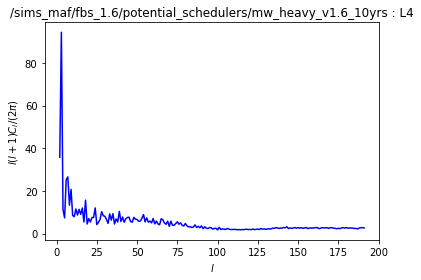

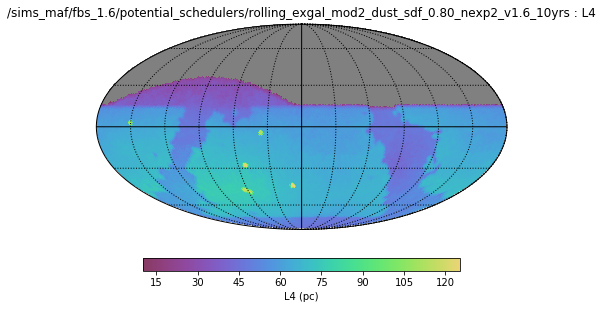

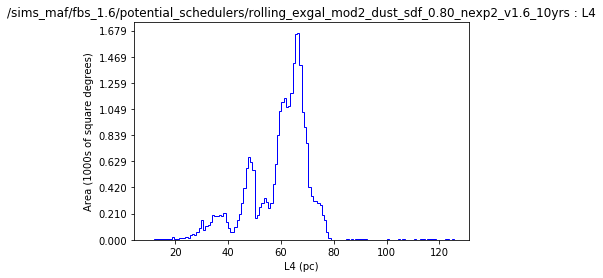

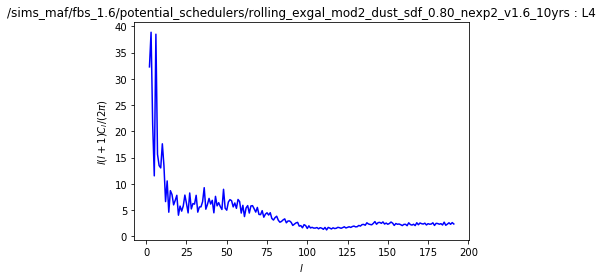

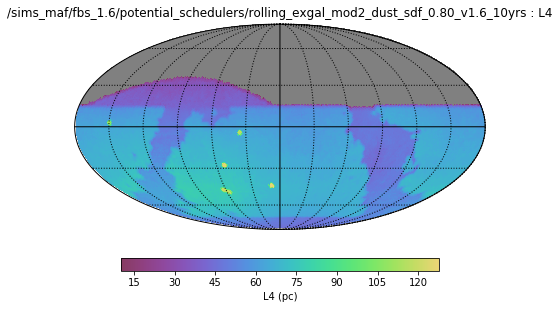

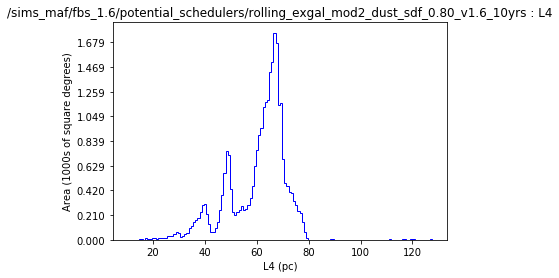

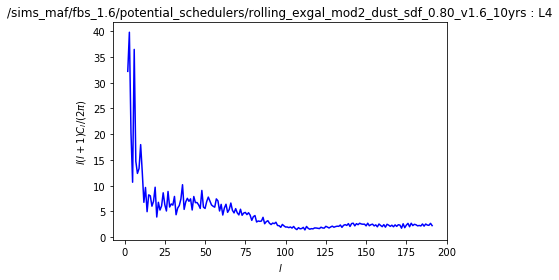

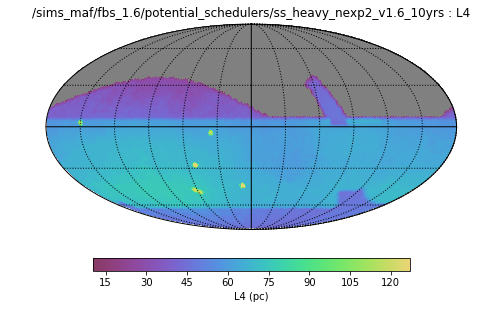

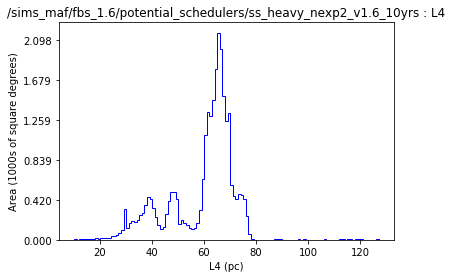

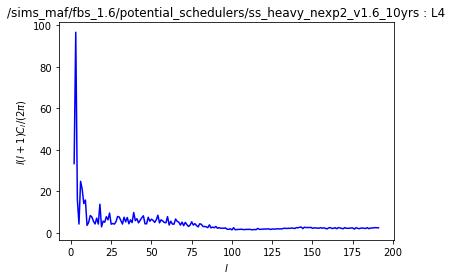

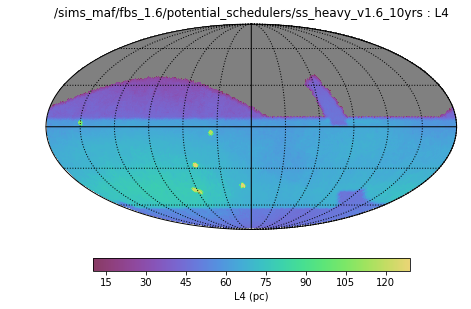

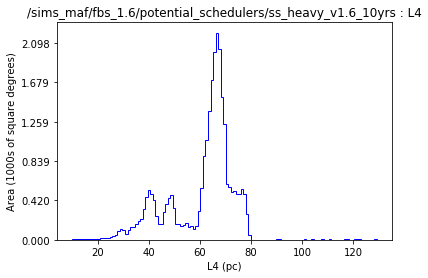

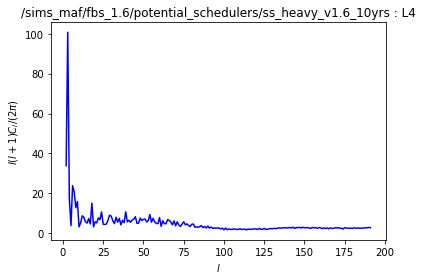

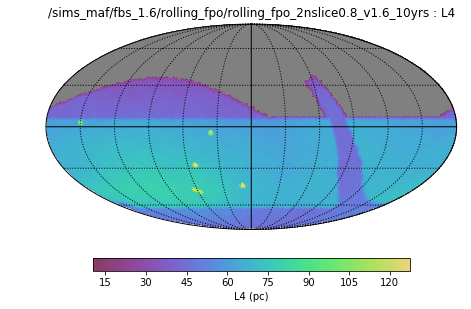

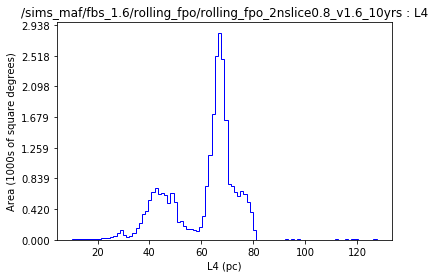

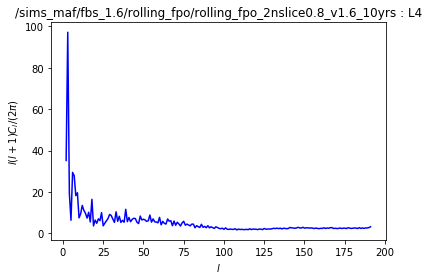

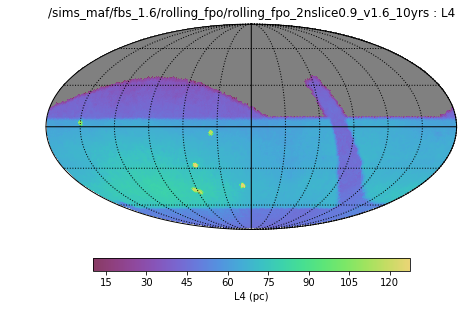

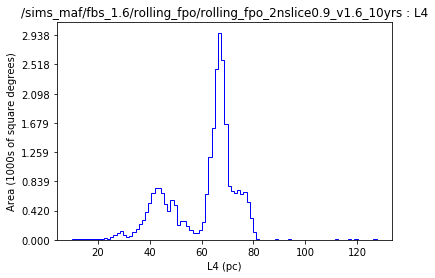

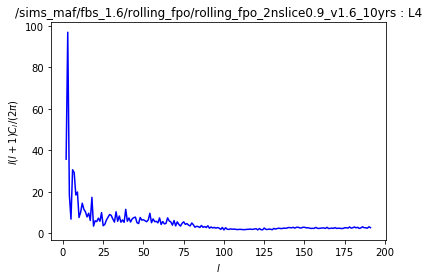

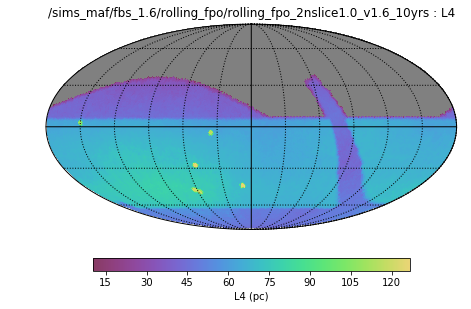

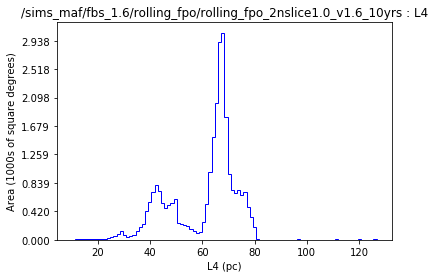

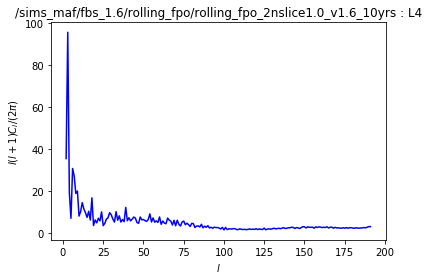

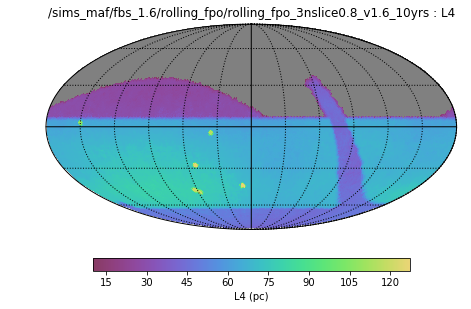

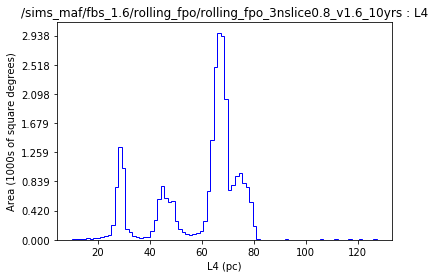

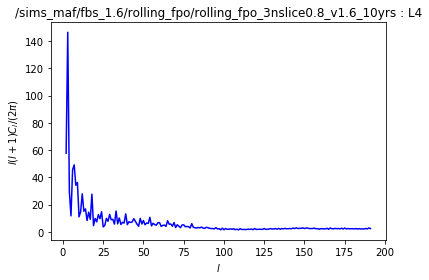

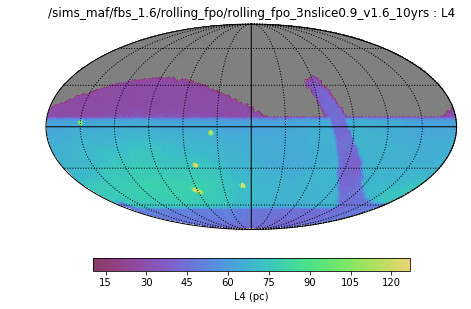

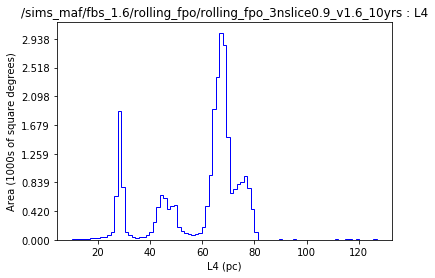

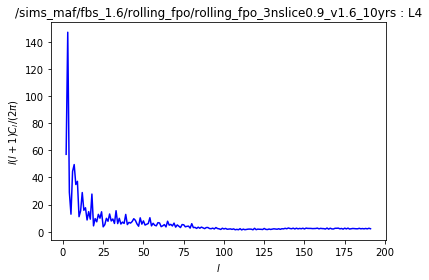

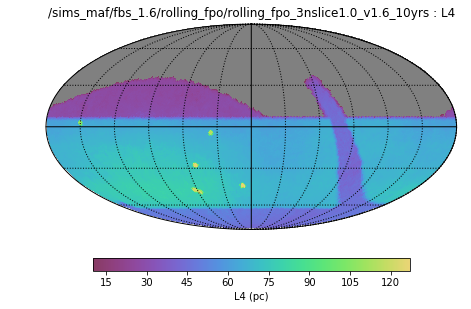

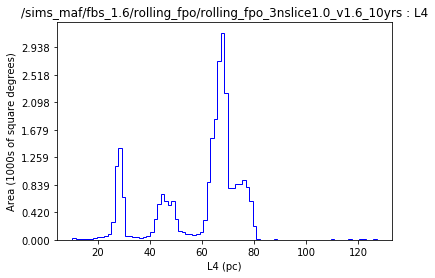

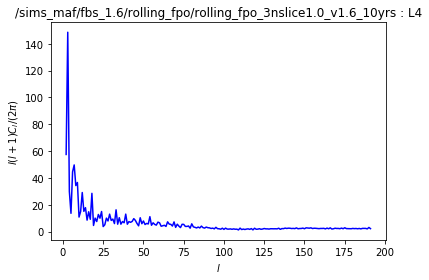

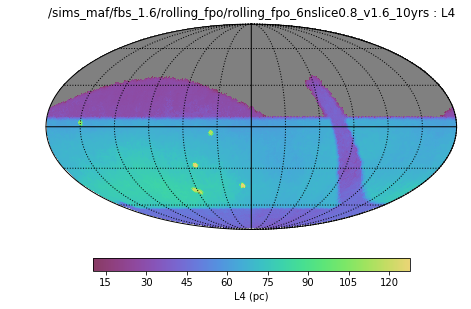

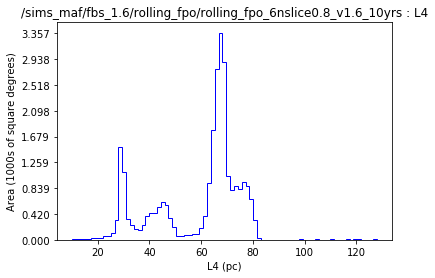

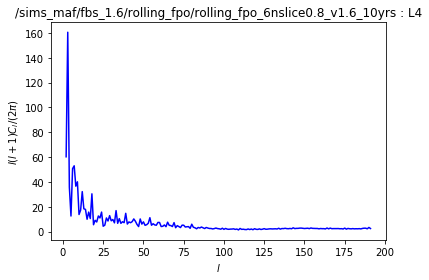

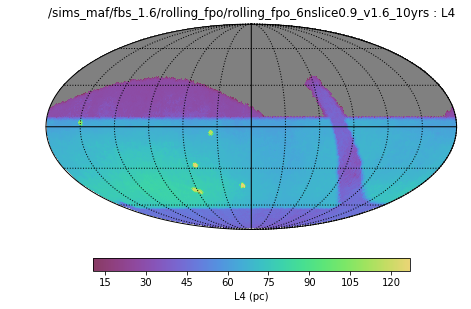

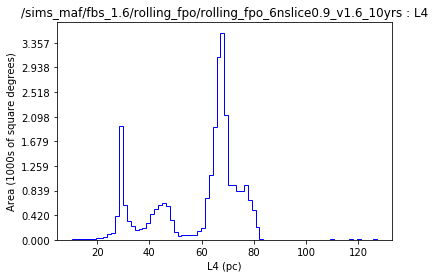

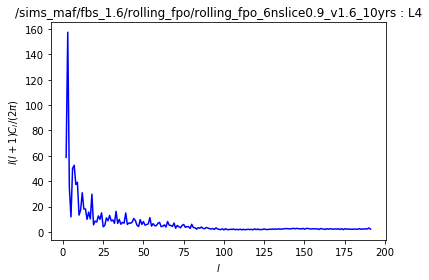

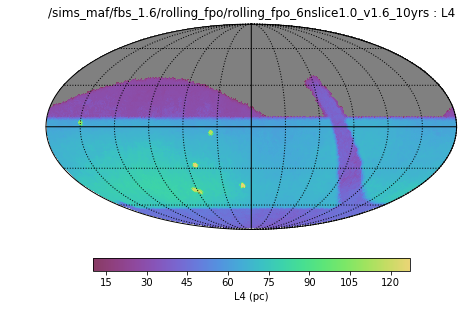

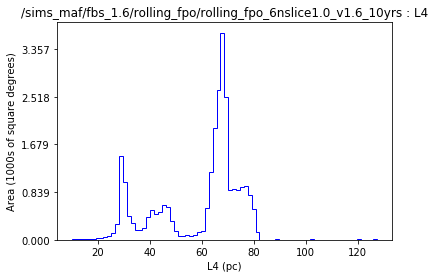

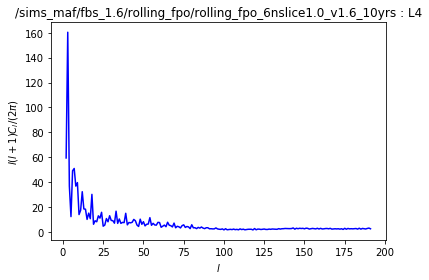

In [4]:
files = glob.glob('/sims_maf/fbs_1.6/*/*.db')
files.sort()
results = []
for dbFile in files:
    
    runName = dbFile.replace('.db', '')
    conn = db.OpsimDatabase(dbFile)
    
    outDir = runName + '_bdvol'
    outDir=outDir.replace('/sims_maf/fbs_1.6/',"L4results/")
    resultsDb = db.ResultsDb(outDir=outDir)
    
    nside = 64
    bundleList = []
    #sql = 'filter="z" or filter="y"'
    sql = ''
    # Let's plug in the magnitudes for one type
    metric = BDParallaxMetric(mags={'i': 18.35, 'z': 16.68, 'y': 15.66}, metricName='L4')
    slicer = slicers.HealpixSlicer(nside=nside)
    summaryStats = [VolumeSumMetric(nside=nside)]
    plotDict = {}
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                                 summaryMetrics=summaryStats,
                                                 runName=runName))
    # add DCR degeneracy check...
    #sql = 'filter="z" or filter="y"'
    #metric = metrics.ParallaxDcrDegenMetric(SedTemplate='M', rmag=20.)
    #bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
    #                                         runName=runName))
    
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    bg.plotAll(closefigs=False)

    results.append(bg)

In [5]:
# Let's see how the total volume changes as we change the footprint
for name, result in zip(files, results):
    key = list(result.bundleDict.keys())[0]
    result.bundleDict[key]
    print(name, result.bundleDict[key].summaryValues)

/sims_maf/fbs_1.6/even_filters/even_filters_alt_g_v1.6_10yrs.db {'VolumeSum': 710426.2033401055}
/sims_maf/fbs_1.6/even_filters/even_filters_altv1.6_10yrs.db {'VolumeSum': 707559.2562455682}
/sims_maf/fbs_1.6/even_filters/even_filters_g_v1.6_10yrs.db {'VolumeSum': 714267.3496307962}
/sims_maf/fbs_1.6/even_filters/even_filtersv1.6_10yrs.db {'VolumeSum': 710546.1706559567}
/sims_maf/fbs_1.6/potential_schedulers/barebones_nexp2_v1.6_10yrs.db {'VolumeSum': 665939.3557767423}
/sims_maf/fbs_1.6/potential_schedulers/barebones_v1.6_10yrs.db {'VolumeSum': 705639.6516663773}
/sims_maf/fbs_1.6/potential_schedulers/baseline_nexp1_v1.6_10yrs.db {'VolumeSum': 708043.9453720048}
/sims_maf/fbs_1.6/potential_schedulers/baseline_nexp2_scaleddown_v1.6_10yrs.db {'VolumeSum': 663670.1252117952}
/sims_maf/fbs_1.6/potential_schedulers/baseline_nexp2_v1.6_10yrs.db {'VolumeSum': 668222.8945606512}
/sims_maf/fbs_1.6/potential_schedulers/combo_dust_nexp2_v1.6_10yrs.db {'VolumeSum': 671193.8695679698}
/sims_maf/f